In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

import os
import glob

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Concatenate, Dense, Conv2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras.regularizers import l1_l2

In [10]:
with h5py.File('../data/processed_data/background_for_training_dataset.h5', 'r') as hf:
    X_train = hf['X_train'][:]
    X_test = hf['X_test'][:]
    X_val = hf['X_val'][:]
    X_discovery = hf['X_discovery'][:]

# Load signal data
with h5py.File('../data/processed_data/Ato4l_lepFilter_13TeV_filtered_dataset.h5', 'r') as hf:
    Ato4l_data = hf['Data'][:]

with h5py.File('../data/processed_data/hToTauTau_13TeV_PU20_filtered_dataset.h5', 'r') as hf:
    hToTauTau_data = hf['Data'][:]

with h5py.File('../data/processed_data/hChToTauNu_13TeV_PU20_filtered_dataset.h5', 'r') as hf:
    hChToTauNu_data = hf['Data'][:]

with h5py.File('../data/processed_data/leptoquark_LOWMASS_lepFilter_13TeV_filtered_dataset.h5', 'r') as hf:
    leptoquark_data = hf['Data'][:]

print("Data loaded from processed datasets")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_discovery shape: {X_discovery.shape}")
print(f"Ato4l_data shape: {Ato4l_data.shape}")
print(f"hToTauTau_data shape: {hToTauTau_data.shape}")
print(f"hChToTauNu_data shape: {hChToTauNu_data.shape}")
print(f"leptoquark_data shape: {leptoquark_data.shape}")

Data loaded from processed datasets
X_train shape: (7748303, 57)
X_test shape: (2421345, 57)
X_val shape: (1937076, 57)
X_discovery shape: (1345191, 57)
Ato4l_data shape: (55969, 57)
hToTauTau_data shape: (691283, 57)
hChToTauNu_data shape: (760272, 57)
leptoquark_data shape: (340544, 57)


In [11]:
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# import pickle

# # Fit StandardScaler on background training data
# scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)
# X_discovery_scaled = scaler.transform(X_discovery)

# # Transform signal data
# Ato4l_data_scaled = scaler.transform(Ato4l_data)
# hToTauTau_data_scaled = scaler.transform(hToTauTau_data)
# hChToTauNu_data_scaled = scaler.transform(hChToTauNu_data)
# leptoquark_data_scaled = scaler.transform(leptoquark_data)

# # Save scaler for later use
# with open('../models/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
from sklearn.preprocessing import StandardScaler
import pickle

# select columns whose 1-based index is a multiple of 3
cols = [i for i in range(X_train.shape[1]) if i % 3 == 0]

# fit scaler on those columns in the background training sample
scaler = StandardScaler().fit(X_train[:, cols])

# helper to apply scaling only to selected columns
def scale(X):
    Xs = X.copy()
    Xs[:, cols] = scaler.transform(X[:, cols])
    return Xs

# apply to all datasets
X_train_scaled      = scale(X_train)
X_val_scaled        = scale(X_val)
X_test_scaled       = scale(X_test)
X_discovery_scaled  = scale(X_discovery)

# signal samples
Ato4l_data_scaled       = scale(Ato4l_data)
hToTauTau_data_scaled   = scale(hToTauTau_data)
hChToTauNu_data_scaled  = scale(hChToTauNu_data)
leptoquark_data_scaled  = scale(leptoquark_data)

# persist scaler
with open('../models/scaler_euclid.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [12]:
# η are at indices 1,4,7,… (i % 3 == 1)
eta_vals = X_train_scaled[:, 1::3].ravel()
# φ are at indices 2,5,8,… (i % 3 == 2)
phi_vals = X_train_scaled[:, 2::3].ravel()

print("η range:", eta_vals.min(), "to", eta_vals.max())
print("φ range:", phi_vals.min(), "to", phi_vals.max())

η range: -3.9999985694885254 to 3.999985933303833
φ range: -3.1415910720825195 to 3.141592502593994


pt range: -1.6979555422700654 to 975.2547262782389


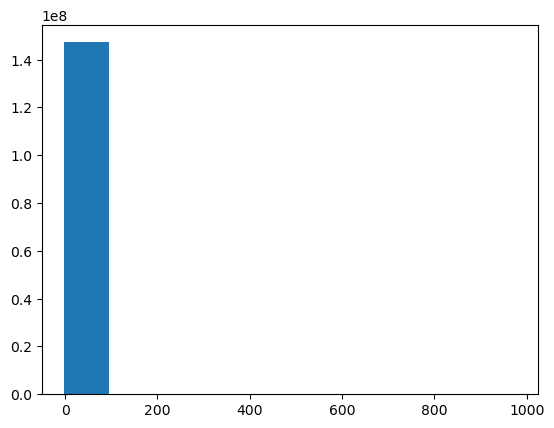

In [13]:
pt_vals = X_train_scaled[:, 0::3].ravel()
print("pt range:", pt_vals.min(), "to", pt_vals.max())
plt.hist(pt_vals)
plt.show()

In [14]:
zero_evt = np.zeros((1, X_train.shape[1]))

# apply your scale() helper
zero_scaled = scale(zero_evt)

# that’s your transformed vector:
print(zero_scaled)

# for a quick check, the non-zero entries should be at `cols` and equal to -(mean_/scale_)  
manual = np.zeros_like(zero_evt)
manual[:, cols] = -scaler.mean_ / scaler.scale_
print("matches:", np.allclose(zero_scaled, manual))

[[-1.69848034  0.          0.         -0.94210126  0.          0.
  -0.1711029   0.          0.         -0.02464476  0.          0.
  -0.00538903  0.          0.         -0.83642067  0.          0.
  -0.15460506  0.          0.         -0.02032678  0.          0.
  -0.00326621  0.          0.         -0.80871874  0.          0.
  -0.5144977   0.          0.         -0.33881044  0.          0.
  -0.20787129  0.          0.         -0.12323925  0.          0.
  -0.07153313  0.          0.         -0.0411576   0.          0.
  -0.02308309  0.          0.         -0.01288785  0.          0.
  -0.00727863  0.          0.        ]]
matches: True


In [15]:
c_vals = (-scaler.mean_ / scaler.scale_).astype(np.float32)
empty_trip = np.zeros((19, 3), dtype=np.float32)
empty_trip[:, 0] = c_vals
empty_trip = tf.constant(empty_trip)

In [16]:
# Use scaled data for training
signal_dict = {
    'hToTauTau': hToTauTau_data_scaled,
    'Ato4l': Ato4l_data_scaled,
    'hChToTauNu': hChToTauNu_data_scaled,
    'leptoquark': leptoquark_data_scaled
}

In [17]:
np.isnan(X_val_scaled).any()

False

In [18]:
from tensorflow.keras import regularizers, initializers

class SignalSamplingSequence(keras.utils.Sequence):
    """Custom data generator for VAE training with signal sampling"""
    
    def __init__(self, X_background, signal_data_dict, batch_size=32, n_signal_samples=1000):
        """
        Args:
            X_background: Background training data
            signal_data_dict: Dictionary of signal data {signal_name: data}
            batch_size: Batch size for background
            n_signal_samples: Number of samples to take from each signal
        """
        self.X_background = X_background
        self.signal_data_dict = signal_data_dict
        self.batch_size = batch_size
        self.n_signal_samples = n_signal_samples
        self.n_batches = len(X_background) // batch_size
    
    def sample_signals(self):
        """Randomly sample signals for current batch"""
        sampled_signals = {}
        for signal_name, signal_data in self.signal_data_dict.items():
            if signal_name != 'BSMchannel':
                n_available = len(signal_data)
                n_to_sample = min(self.n_signal_samples, n_available)
                indices = np.random.choice(n_available, n_to_sample, replace=False)
                sampled_signals[signal_name] = signal_data[indices]
        return sampled_signals
    
    def __len__(self):
        return self.n_batches
    
    def __getitem__(self, idx):
        # Get background batch
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        background_batch = self.X_background[start_idx:end_idx]
        
        # Sample signals for this batch
        sampled_signals = self.sample_signals()
        
        # Return background and sampled signals
        return (background_batch, sampled_signals)
    
    def on_epoch_end(self):
        """Called at the end of each epoch"""
        # Shuffle background data if needed
        pass


# --------------------------------------------------------------
# helper: cyclic β and linear-warmup γ
# --------------------------------------------------------------
# def cyclic_beta(global_step, steps_per_epoch, cycle_len, bmin, bmax):
#     epoch = tf.cast(global_step, tf.float32) / tf.cast(steps_per_epoch, tf.float32)
#     c = tf.floor(1. + epoch / cycle_len)
#     x = tf.abs(epoch / cycle_len - c + 1.)
#     return bmin + (bmax - bmin) * tf.minimum(x, 1.)
def cyclic_beta(global_step, steps_per_epoch, cycle_len, bmin, bmax):
    # convert global step to fractional epochs
    epoch = tf.cast(global_step, tf.float32) / tf.cast(steps_per_epoch, tf.float32)
    # position within the current cycle [0, cycle_len)
    cycle_pos = tf.math.floormod(epoch, cycle_len)
    # normalized position [0,1)
    frac = cycle_pos / cycle_len

    # ramp up over first half, hold at 1 over second half
    ramp_frac = frac * 2.0
    scaled = tf.where(frac < 0.5,
                      ramp_frac,
                      tf.ones_like(frac))

    # map [0,1] → [bmin,bmax]
    return bmin + (bmax - bmin) * scaled
def warm_gamma(global_step, steps_per_epoch, warm_epochs, gmax):
    # epoch counter (float)
    e = tf.cast(global_step, tf.float32) / tf.cast(steps_per_epoch, tf.float32)
    # 0 for e < warm_epochs
    # linear ramp to 1 for warm_epochs ≤ e < 2*warm_epochs
    # 1 for e ≥ 2*warm_epochs
    return gmax * tf.clip_by_value((e - warm_epochs) / warm_epochs, 0., 1.)



L2   = 1e-3          # weight-decay factor
DROPOUT = 0.1        # after each hidden layer
# --------------------------------------------------------------
# main model
# --------------------------------------------------------------
class VAEContrastive(keras.Model):
    def __init__(
        self,
        input_dim,
        hidden_dims,        # list, e.g. [256,64,32]
        latent_dim,
        *,
        steps_per_epoch,
        cycle_length=10,
        beta_min=0.1,
        beta_max=0.85,
        warmup_epochs=5,
        gamma_max=1.0,
        **kw,
    ):
        super().__init__(**kw)
        self.steps_per_epoch = tf.constant(steps_per_epoch, tf.int32)
        self.cycle_len = float(cycle_length)
        self.bmin, self.bmax = float(beta_min), float(beta_max)
        self.warm_epochs = float(warmup_epochs)
        self.gmax = float(gamma_max)
        self.empty_trip = tf.constant(empty_trip)

        # ─ encoder ─
        enc_in = keras.Input(input_dim)
        x = enc_in
        x = layers.BatchNormalization()(x)
        for h in hidden_dims:
            x = layers.Dense(
                h,
                kernel_initializer='he_normal', 
                bias_initializer=initializers.Constant(0.001),            # better for LeakyReLU
                kernel_regularizer=regularizers.l2(L2)
            )(x)
            x = layers.LeakyReLU(0.3)(x)
            x = layers.BatchNormalization()(x)
        z_mean = layers.Dense(latent_dim)(x)
        z_logv = layers.Dense(latent_dim, bias_initializer=initializers.Constant(-2.0))(x)
        z_logv = tf.clip_by_value(z_logv, -10., 10.)
        z = layers.Lambda(lambda t: t[0] + tf.exp(0.5 * t[1]) * tf.random.normal(tf.shape(t[0])))([z_mean, z_logv])
        self.encoder = keras.Model(enc_in, [z_mean, z_logv, z], name="encoder")

        # ─ decoder ─
        dec_in = keras.Input(latent_dim)
        x = dec_in
        for h in reversed(hidden_dims):
            x = layers.Dense(
                h,
                kernel_initializer='he_normal', 
                bias_initializer=initializers.Constant(0.001),            # better for LeakyReLU
                kernel_regularizer=regularizers.l2(L2)
            )(x)
            x = layers.LeakyReLU(0.3)(x)
            x = layers.BatchNormalization()(x)
        raw = layers.Dense(input_dim)(x)

        # reshape → (batch,19,3)
        x3 = layers.Reshape((19, 3))(raw)

        # split channels
        other = x3[...,0:1]          # “whatever” feature
        eta_raw = x3[...,1:2]        # raw η
        phi_raw = x3[...,2:3]        # raw φ

        # constrain η ∈ [–3,3]
        eta = layers.Activation('tanh')(eta_raw)
        eta = layers.Lambda(lambda t: t * 4.0)(eta)

        # constrain φ ∈ [–π,π]
        phi = layers.Activation('tanh')(phi_raw)
        phi = layers.Lambda(lambda t: t * np.pi)(phi)

        # re-assemble and flatten
        out3 = layers.Concatenate(axis=-1)([other, eta, phi])  # (B,19,3)
        dec_out = layers.Reshape((input_dim,))(out3)

        self.decoder = keras.Model(dec_in, dec_out, name="decoder")

        # trackers
        self.total_loss_tracker          = keras.metrics.Mean("total")
        self.recon_tracker               = keras.metrics.Mean("recon")
        self.kl_tracker                  = keras.metrics.Mean("kl")
        self.contrast_tracker            = keras.metrics.Mean("contrast")
        self.beta_tracker                = keras.metrics.Mean("beta")
        self.gamma_tracker               = keras.metrics.Mean("gamma")

        self.global_step = tf.Variable(0, trainable=False, dtype=tf.int32)

    @property
    def metrics(self):
        return [ self.total_loss_tracker, self.recon_tracker,
                 self.kl_tracker, self.contrast_tracker,
                 self.beta_tracker, self.gamma_tracker ]

    # ─ contrastive loss (InfoNCE style, averaged) ─
    def contrastive(self, signal_latents_dict, k=100):
        """
        Info-NCE over *signals only*.
        Positives = same-signal pairs (excluding self);
        Negatives = all other signal samples.
        """
        if not signal_latents_dict:
            return tf.constant(0.0, tf.float32)

        # ─ concatenate latents and build class labels ─
        all_latents, labels = [], []
        for idx, (name, z_sig) in enumerate(signal_latents_dict.items()):
            all_latents.append(z_sig)
            labels.append(tf.fill([tf.shape(z_sig)[0]], idx))
        z_sig  = tf.concat(all_latents, 0)          # [n_sig , d]
        labels = tf.concat(labels,     0)           # [n_sig]

        # ─ similarity matrix (euclid) ─
        tau  = 0.05
        sq   = tf.reduce_sum(tf.square(z_sig), axis=1, keepdims=True)          # ‖z_i‖²
        dist = sq - 2.0 * tf.matmul(z_sig, z_sig, transpose_b=True) + tf.transpose(sq)  # ‖Δ‖²
        sim  = tf.exp(-dist / tau)

        n_sig = tf.shape(z_sig)[0]
        eye   = tf.eye(n_sig, dtype=tf.float32)
        sim_no_self = sim * (1.0 - eye)              # remove self-similarity

        # positive mask: same class, not self
        lab = tf.expand_dims(labels, 1)
        pos_mask = tf.cast(tf.equal(lab, tf.transpose(lab)), tf.float32) * (1.0 - eye)

        # A(x) = sum_{pos} sim
        A = tf.reduce_sum(sim * pos_mask, 1)
        # B(x) = sum_{all≠x} sim
        B = tf.reduce_sum(sim_no_self, 1)

        A = tf.maximum(A, 1e-6);  B = tf.maximum(B, 1e-6)
        return -tf.reduce_mean(tf.math.log(A / B))
    
    def masked_mse(self, x, recon):
        # reshape into (B, num_objs, 3)
        x3 = tf.reshape(x, [-1, 19, 3])

        # compare to empty_trip within tolerance
        eq0 = tf.abs(x3 - self.empty_trip[None, ...]) < 1e-6
        empty_mask = tf.reduce_all(eq0, axis=-1)             # (B, num_objs)

        # expand to (B,57)
        mask3 = tf.reshape(
            tf.repeat(empty_mask[..., None], repeats=3, axis=-1),
            [-1, input_dim]
        )
        keep = 1.0 - tf.cast(mask3, tf.float32)

        # masked MSE
        sq = tf.square(x - recon)
        return tf.reduce_sum(sq * keep) / tf.reduce_sum(keep)


    def contrastive_hard(self, signal_latents_dict, k=100):
        """
        Hard-mined InfoNCE.
        • Numerator  A = Σ (k farthest positives)      – lowest cosine-sim entries
        • Denominator B = Σ (k closest  negatives)     – highest cosine-sim entries
        Assumes every anchor has ≥ k positives and ≥ k negatives.
        """
        if not signal_latents_dict:
            return tf.constant(0.0, tf.float32)

        # ─ concat latents & labels ─
        z_list, lbl_list = [], []
        for cls_id, (_, z) in enumerate(signal_latents_dict.items()):
            z_list.append(z)
            lbl_list.append(tf.fill([tf.shape(z)[0]], cls_id))
        z_sig  = tf.concat(z_list, 0)       # [N , d]
        labels = tf.concat(lbl_list, 0)     # [N]

        # ─ similarity matrix (exp(cos)) ─
        nz  = tf.nn.l2_normalize(z_sig, 1)
        sim = tf.exp(tf.matmul(nz, nz, transpose_b=True)/0.05)   # [N , N]

        N   = tf.shape(z_sig)[0]
        eye = tf.eye(N, dtype=tf.float32)

        lab = tf.expand_dims(labels, 1)
        pos_mask = tf.cast(tf.equal(lab, tf.transpose(lab)), tf.float32) * (1.0 - eye)
        neg_mask = (1.0 - eye) - pos_mask

        # farthest positives: smallest sims
        pos_sims = tf.where(pos_mask > 0,
                            sim,
                            tf.fill(tf.shape(sim), tf.float32.max))
        hardest_pos = -tf.nn.top_k(-pos_sims, k=k, sorted=False).values   # [N , k]

        # closest negatives: largest sims
        neg_sims = tf.where(neg_mask > 0,
                            sim,
                            tf.fill(tf.shape(sim), tf.float32.min))
        hardest_neg = tf.nn.top_k(neg_sims, k=k, sorted=False).values     # [N , k]

        A = tf.reduce_sum(hardest_pos, axis=1)        # numerator
        B = tf.reduce_sum(hardest_neg, axis=1)        # denominator

        eps = 1e-6
        return -tf.reduce_mean(tf.math.log(tf.maximum(A, eps) / (tf.maximum(B, eps) + tf.maximum(A, eps))))
 
    # ─ training step ─
    def train_step(self, data):
        bg, sig = data if isinstance(data, tuple) else (data, {})
        β = cyclic_beta(self.global_step, self.steps_per_epoch, self.cycle_len, self.bmin, self.bmax)
        γ = warm_gamma(self.global_step, self.steps_per_epoch, self.warm_epochs, self.gmax)

        with tf.GradientTape(persistent=True) as tape:
            μ, logv, z_bg = self.encoder(bg)
            recon = self.decoder(z_bg)

            recon_loss = self.masked_mse(bg, recon)
            kl = tf.reduce_mean(-0.5 * (1 + logv - tf.square(μ) - tf.exp(logv)))
            sig_lat = {k: self.encoder(v)[-1] for k, v in sig.items() if k != "BSMchannel"}
            #contrast = self.contrastive_hard(sig_lat, k=500)
            contrast = self.contrastive(sig_lat)

            loss = (1-β) * recon_loss + β * kl + γ * contrast

        vars_ = self.trainable_weights
        g_recon    = tape.gradient(recon_loss, vars_)
        g_kl       = tape.gradient(kl,         vars_)
        g_contrast = tape.gradient(contrast,   vars_)
        g_total    = tape.gradient(loss,       vars_)
        del tape

        # pad Nones with zeros so all vectors share |θ| dimensions
        def flat(glist):
            return tf.concat(
                [tf.reshape(g if g is not None else tf.zeros_like(v), [-1])
                for g, v in zip(glist, vars_)],
                axis=0)

        v_recon, v_kl, v_contrast = map(flat, (g_recon, g_kl, g_contrast))

        # cosine similarities (<0 ⇒ conflict)
        sim_kl_recon  = tf.tensordot(v_kl, v_recon, 1) / (tf.norm(v_kl)*tf.norm(v_recon)+1e-9)
        sim_con_recon = tf.tensordot(v_contrast, v_recon, 1) / (tf.norm(v_contrast)*tf.norm(v_recon)+1e-9)
        sim_con_kl    = tf.tensordot(v_contrast, v_kl, 1) / (tf.norm(v_contrast)*tf.norm(v_kl)+1e-9)

        self.optimizer.apply_gradients(zip(g_total, vars_))
        self.global_step.assign_add(1)

        self.recon_tracker.update_state(recon_loss)
        self.kl_tracker.update_state(kl)
        self.contrast_tracker.update_state(contrast)
        self.beta_tracker.update_state(β)
        self.gamma_tracker.update_state(γ)

        return {"loss": loss,
                "recon": self.recon_tracker.result(),
                "kl":    self.kl_tracker.result(),
                "contrast": self.contrast_tracker.result(),
                "beta": self.beta_tracker.result(),
                "gamma": self.gamma_tracker.result(),
                "sim_kl_recon": sim_kl_recon,
                "sim_con_recon": sim_con_recon,
                "sim_con_kl": sim_con_kl}

    # ─ inference ─
    def call(self, x):
        μ, logv, z = self.encoder(x)
        return {"z_mean": μ, "z_log_var": logv, "reconstruction": self.decoder(z)}
    def test_step(self, data):
        bg, sig = data if isinstance(data, tuple) else (data, {})

        beta   = self.bmax            # use max values
        gamma  = self.gmax

        # forward pass
        μ, logv, z_bg = self.encoder(bg, training=False)
        recon         = self.decoder(z_bg, training=False)

        # losses
        recon_loss = self.masked_mse(bg, recon)

        kl = -0.5 * (1. + logv - tf.square(μ) - tf.exp(logv))
        kl = tf.reduce_mean(kl)

        sig_lat = {k: self.encoder(v, training=False)[-1]
                   for k, v in sig.items() if k != "BSMchannel"}
        contrast = self.contrastive(sig_lat)

        loss = (1. - beta) * recon_loss + beta * kl + gamma * contrast

        # update trackers
        self.total_loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_loss)
        self.kl_tracker.update_state(kl)
        self.contrast_tracker.update_state(contrast)
        self.beta_tracker.update_state(beta)
        self.gamma_tracker.update_state(gamma)

        return {
            "loss": loss,
            "recon": recon_loss,
            "kl": kl,
            "contrast": contrast,
            "beta": beta,
            "gamma": gamma,
        }

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Import the VAE model and data generator from the previous file
# from vae_contrastive_model import VAEWithContrastive, SignalSamplingSequence, EpochCounterCallback

# Load data
print("Loading data...")

# Model parameters
input_dim = X_train.shape[1]
hidden_dims = [32,16]#[256, 128, 32]
latent_dim = 3
batch_size = 4096*4

# Training parameters
epochs = 50
warmup_epochs = 10
beta_min = 0.0
beta_max = 0.25
cycle_length = 10
gamma = 2
learning_rate = 1e-3

steps_per_epoch = len(X_train_scaled) // batch_size
lr_warmup_epochs = 10 
lr_steps_warmup  = steps_per_epoch * lr_warmup_epochs
lr_steps_cosine  = steps_per_epoch * (epochs - lr_warmup_epochs)
lr_warmup = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-6,
    end_learning_rate=1e-5,
    decay_steps=lr_steps_warmup,
    power=1.0)

lr_cosine = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=lr_steps_cosine,
    alpha=0.1)      

class WarmupCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup, cosine, transition):
        super().__init__()
        self.warmup      = warmup
        self.cosine      = cosine
        self.transition  = tf.constant(transition, dtype=tf.int64)

    def __call__(self, step):
        step = tf.cast(step, tf.int64)
        return tf.cond(step < self.transition,
                       lambda: self.warmup(step),
                       lambda: self.cosine(step - self.transition))

    def get_config(self):   # makes the schedule serialisable
        return {
            "warmup":      keras.saving.serialize_keras_object(self.warmup),
            "cosine":      keras.saving.serialize_keras_object(self.cosine),
            "transition":  int(self.transition.numpy()),
        }

lr_schedule = WarmupCosine(lr_warmup, lr_cosine, lr_steps_warmup)

# Create model
print("\nCreating VAE model...")
vae = VAEContrastive(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    steps_per_epoch=steps_per_epoch,   # always first of the sched-params
    cycle_length=cycle_length,         # β cycle
    beta_min=beta_min,
    beta_max=beta_max,
    warmup_epochs=warmup_epochs,       # γ warm-up
    gamma_max=gamma                    # rename: gamma → gamma_max
)

vae.compile(optimizer=keras.optimizers.AdamW(lr_schedule, clipnorm=0.5, weight_decay=1e-4))

# Update train generator with scaled data
train_generator = SignalSamplingSequence(
    X_train_scaled, 
    signal_dict,
    batch_size=batch_size,
    n_signal_samples=1000
)

val_generator = SignalSamplingSequence(
    X_val_scaled,
    signal_dict,
    batch_size=batch_size,
    n_signal_samples=1000)

# Train model
print("\nStarting training...")
history = vae.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1
)

# Save the trained model
print("\nSaving model...")
vae.encoder.save('../models/vae_encoder_10epochs_euclid.h5')
vae.decoder.save('../models/vae_decoder_10epochs_euclid.h5')

Loading data...

Creating VAE model...

Starting training...
Epoch 1/50
472/472 [==============================] - 94s 188ms/step - loss: 8.2616 - recon: 8.3826 - kl: 2.8841 - contrast: 1.8480 - beta: 0.0249 - gamma: 0.0000e+00 - sim_kl_recon: 0.5312 - sim_con_recon: 0.0312 - sim_con_kl: 0.0135 - val_loss: 10.2929 - val_recon: 7.6530 - val_kl: 3.2426 - val_contrast: 1.8712 - val_beta: 0.2500 - val_gamma: 2.0000
Epoch 2/50
472/472 [==============================] - 86s 183ms/step - loss: 7.5654 - recon: 7.9557 - kl: 2.7530 - contrast: 1.8402 - beta: 0.0749 - gamma: 0.0000e+00 - sim_kl_recon: 0.5143 - sim_con_recon: 0.0215 - sim_con_kl: -0.0108 - val_loss: 10.2253 - val_recon: 7.7533 - val_kl: 3.0779 - val_contrast: 1.8204 - val_beta: 0.2500 - val_gamma: 2.0000
Epoch 3/50
472/472 [==============================] - 86s 183ms/step - loss: 6.8200 - recon: 7.4226 - kl: 2.5822 - contrast: 1.8268 - beta: 0.1249 - gamma: 0.0000e+00 - sim_kl_recon: 0.4892 - sim_con_recon: 0.0402 - sim_con_kl: 0.

/eos/home-h/hjia/miniforge3/envs/ML_env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


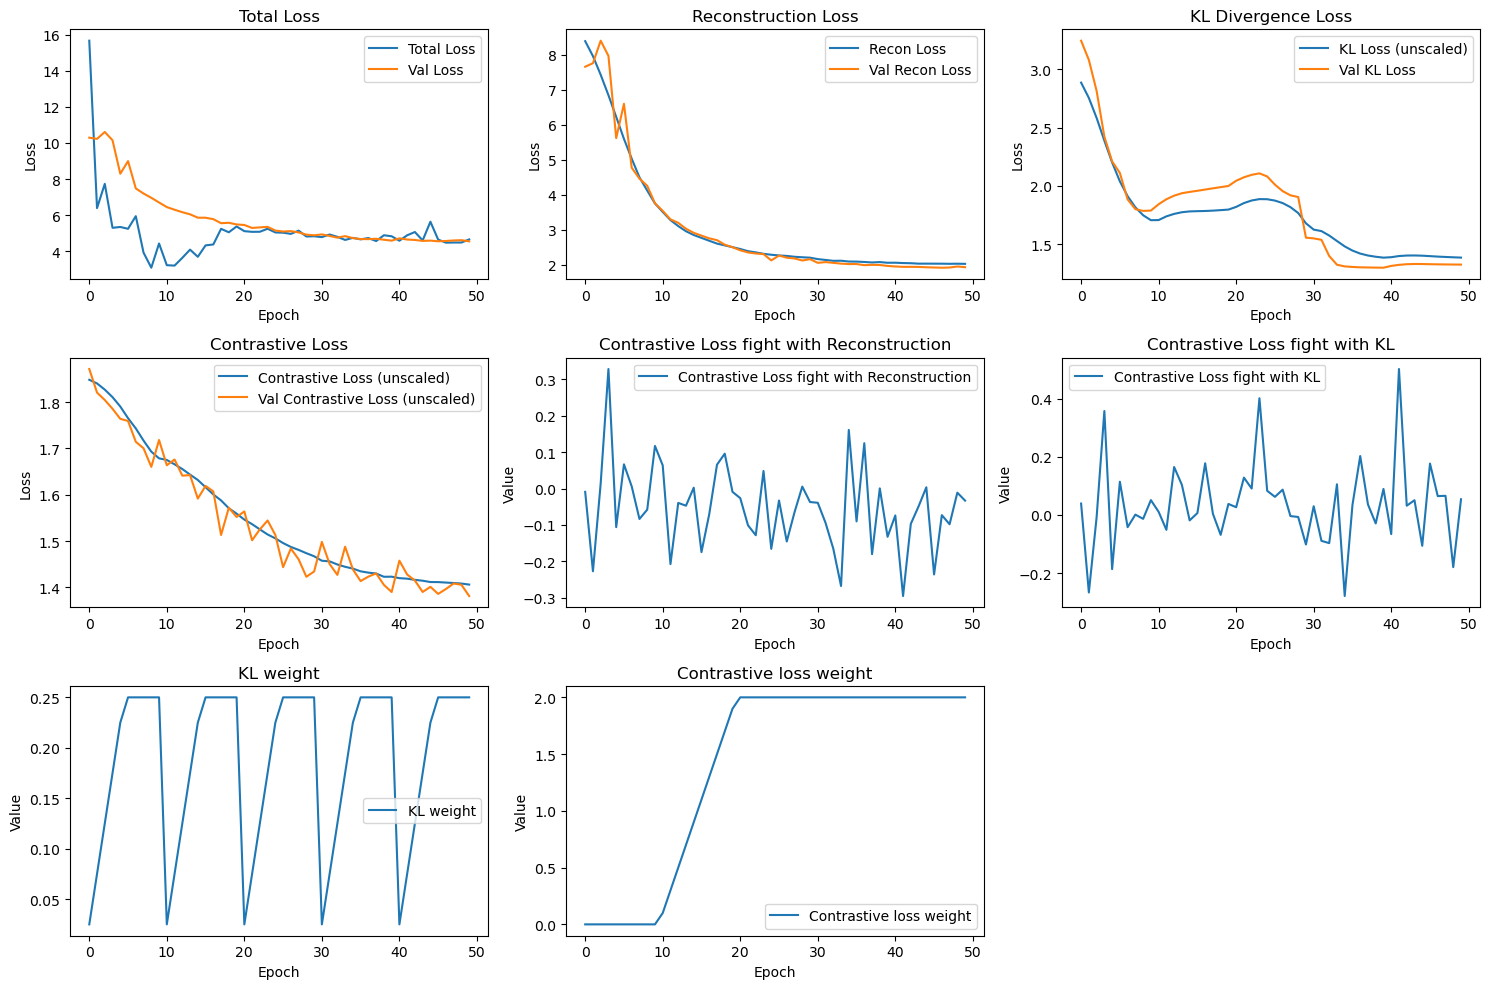

In [20]:
# Plot training history
plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(history.history['recon'], label='Recon Loss')
plt.plot(history.history['val_recon'], label='Val Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(history.history['kl'], label='KL Loss (unscaled)')
plt.plot(history.history['val_kl'], label='Val KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()

plt.subplot(3, 3, 4)
plt.plot(history.history['contrast'], label='Contrastive Loss (unscaled)')
plt.plot(history.history['val_contrast'], label='Val Contrastive Loss (unscaled)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Loss')
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(history.history['sim_con_recon'], label='Contrastive Loss fight with Reconstruction')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Contrastive Loss fight with Reconstruction')
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(history.history['sim_con_kl'], label='Contrastive Loss fight with KL')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Contrastive Loss fight with KL')
plt.legend()

plt.subplot(3, 3, 7)
plt.plot(history.history['beta'], label='KL weight')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('KL weight')
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(history.history['gamma'], label='Contrastive loss weight')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Contrastive loss weight')
plt.legend()

plt.tight_layout()
plt.savefig('../plots/training_history_10epochs_euclid.png')
plt.show()


Generating latent representations...

Plotting latent dimension distributions...


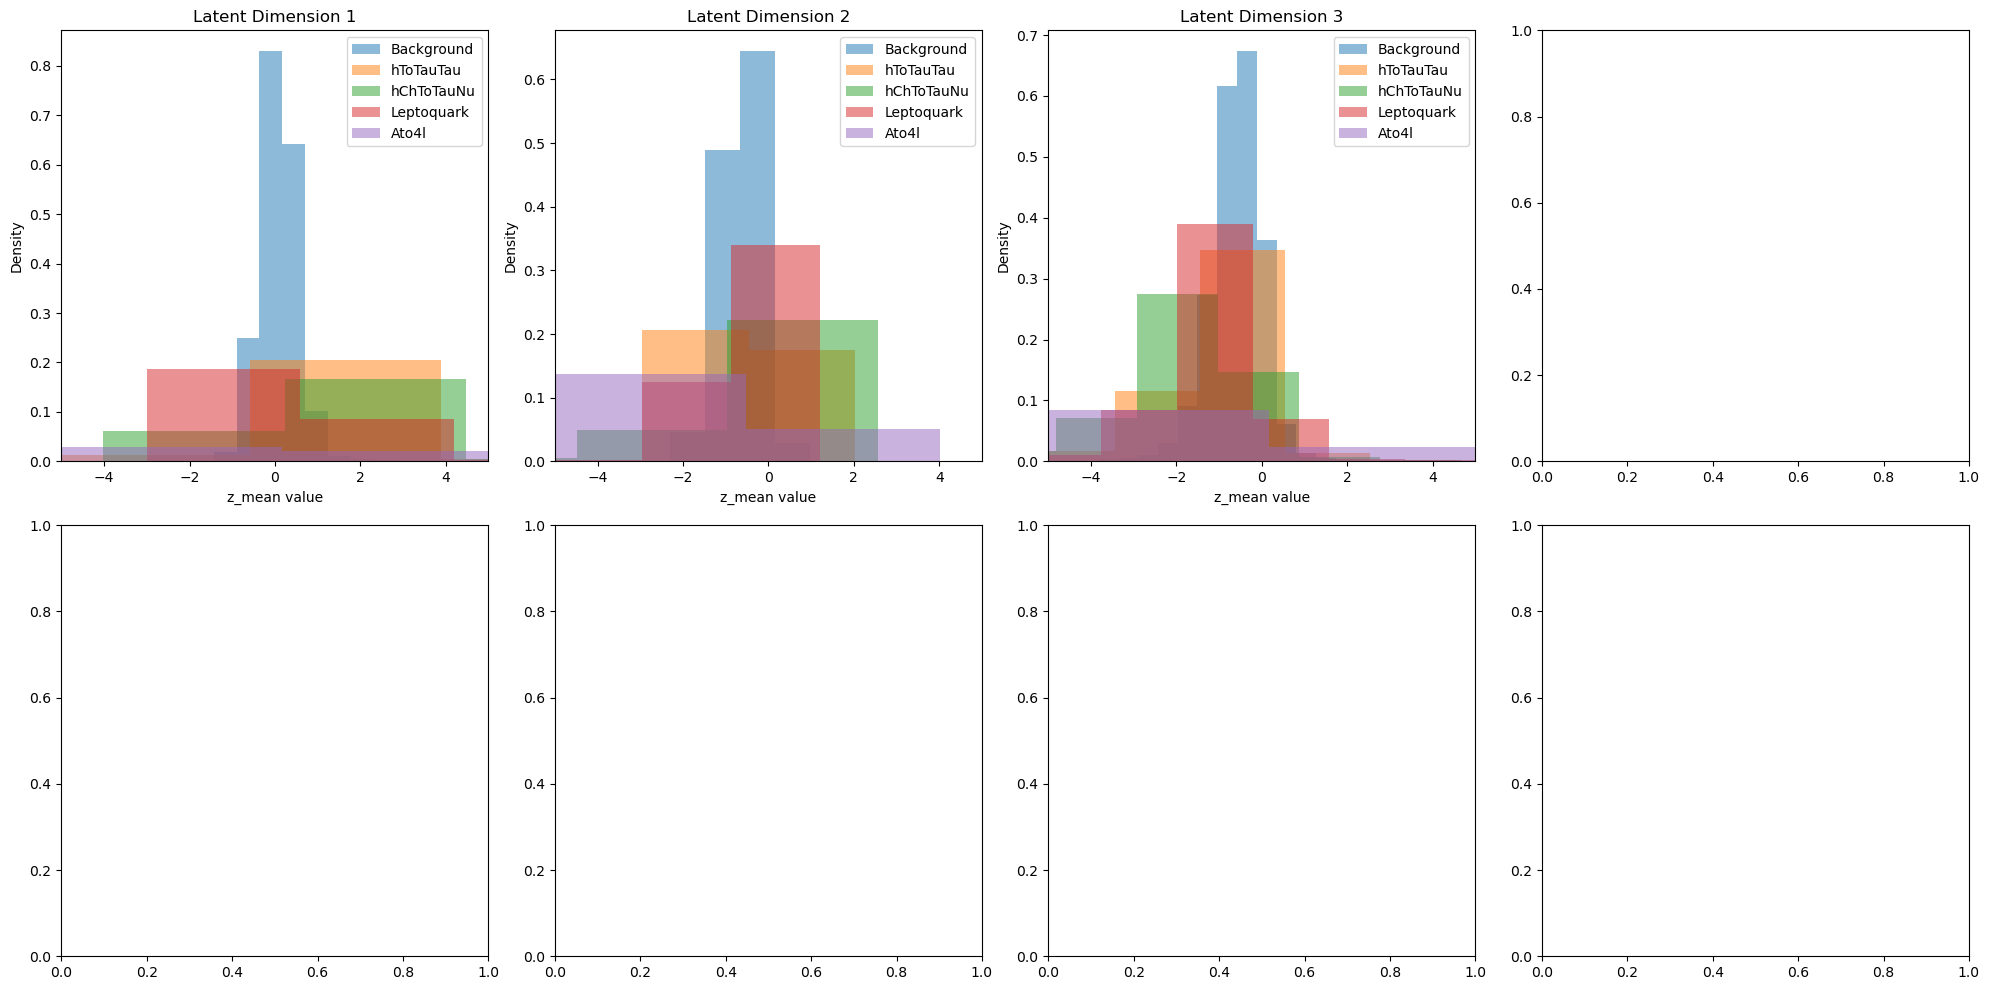

In [21]:

# Get latent representations for all data
print("\nGenerating latent representations...")

def get_latent_mean(encoder, data, batch_size=1000):
    z_means = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        z_mean = encoder.predict(batch, verbose=0)[0]   # [0] = μ
        z_means.append(z_mean)
    return np.concatenate(z_means, axis=0)

# Get latent representations
z_background = get_latent_mean(vae.encoder, X_test_scaled[:20000])
z_hToTauTau = get_latent_mean(vae.encoder, hToTauTau_data_scaled[:20000])
z_hChToTauNu = get_latent_mean(vae.encoder, hChToTauNu_data_scaled[:20000])
z_leptoquark = get_latent_mean(vae.encoder, leptoquark_data_scaled[:20000])
z_Ato4l = get_latent_mean(vae.encoder, Ato4l_data_scaled[:20000])

# Plot latent dimension distributions
print("\nPlotting latent dimension distributions...")
n_dims_to_plot = latent_dim
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for dim in range(n_dims_to_plot):
    ax = axes[dim]
    
    # Plot histograms for each signal type
    ax.hist(z_background[:, dim], bins=30, alpha=0.5, label='Background', density=True)    
    ax.hist(z_hToTauTau[:, dim], bins=30, alpha=0.5, label='hToTauTau', density=True)
    ax.hist(z_hChToTauNu[:, dim], bins=30, alpha=0.5, label='hChToTauNu', density=True)
    ax.hist(z_leptoquark[:, dim], bins=30, alpha=0.5, label='Leptoquark', density=True)
    ax.hist(z_Ato4l[:, dim], bins=30, alpha=0.5, label='Ato4l', density=True)
    
    ax.set_xlim(-5, 5)
    ax.set_title(f'Latent Dimension {dim + 1}')
    ax.set_xlabel('z_mean value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.savefig('../plots/latent_distributions_10epochs_euclid.png')
plt.show()



Generating t-SNE visualization...


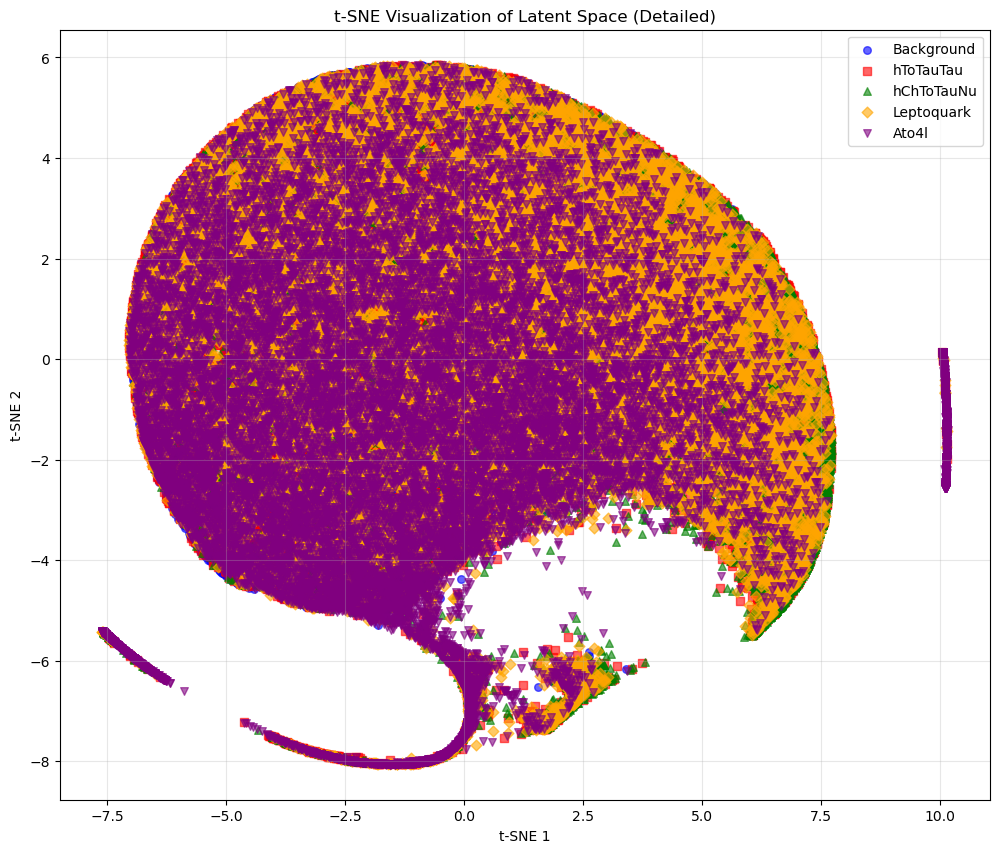


Training completed! Plots saved to ../plots/


In [ ]:

# t-SNE visualization
print("\nGenerating t-SNE visualization...")

# Combine all data for t-SNE
all_z = np.concatenate([z_background, z_hToTauTau, z_hChToTauNu, z_leptoquark, z_Ato4l])
labels = np.concatenate([
    np.zeros(len(z_background)),
    np.ones(len(z_hToTauTau)) * 1,
    np.ones(len(z_hChToTauNu)) * 2,
    np.ones(len(z_leptoquark)) * 3,
    np.ones(len(z_Ato4l)) * 4
])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
z_tsne = tsne.fit_transform(all_z)

# # Plot t-SNE
# plt.figure(figsize=(12, 10))
# scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)

# # Add legend
legend_labels = ['Background', 'hToTauTau', 'hChToTauNu', 'Leptoquark', 'Ato4l']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=plt.cm.tab10(i/10), markersize=10, 
                             label=legend_labels[i]) for i in range(5)]
# plt.legend(handles=legend_elements, loc='best')

# plt.title('t-SNE Visualization of Latent Space')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.savefig('../plots/tsne_latent_space_10epochs.png')
# plt.show()

# Create a more detailed t-SNE plot with contours
plt.figure(figsize=(12, 10))

# Plot each class separately with different markers
markers = ['o', 's', '^', 'D', 'v']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (label, marker, color) in enumerate(zip(legend_labels, markers, colors)):
    mask = labels == i
    plt.scatter(z_tsne[mask, 0], z_tsne[mask, 1], 
               c=color, marker=marker, alpha=0.6, s=30, label=label)

plt.legend()
plt.title('t-SNE Visualization of Latent Space (Detailed)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.savefig('../plots/tsne_latent_space_detailed_10epochs_euclid.png')
plt.show()

print("\nTraining completed! Plots saved to ../plots/")

In [25]:
%pip install "umap-learn<0.6"

Note: you may need to restart the kernel to use updated packages.


In [26]:
import umap.umap_ as umap

# --- UMAP instead of t-SNE ---
print("\nGenerating UMAP visualization...")

reducer = umap.UMAP(
    n_neighbors=30,      # similar role to perplexity
    min_dist=0.1,        # controls clustering tightness
    metric="euclidean",
    random_state=42
)
z_umap = reducer.fit_transform(all_z)

plt.figure(figsize=(12, 10))

# Plot each class separately with different markers
markers = ['o', 's', '^', 'D', 'v']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (label, marker, color) in enumerate(zip(legend_labels, markers, colors)):
    mask = labels == i
    plt.scatter(z_umap[mask, 0], z_umap[mask, 1], 
               c=color, marker=marker, alpha=0.6, s=30, label=label)

plt.legend()
plt.title('UMAP Visualization of Latent Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True, alpha=0.3)
plt.savefig('../plots/umap_latent_space_detailed_10epochs.png')
plt.show()


Generating UMAP visualization...


TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'

In [27]:
from sklearn.metrics import roc_curve, auc
from tqdm import trange

# ------------------------------------------------------------------
# helper: latent anomaly score  =  mean(z_mean**2) per event
# ------------------------------------------------------------------
def anomaly_scores(encoder, data, batch_size=4096):
    """
    Returns a 1-D array of anomaly scores for `data`.
    Score = average of squared latent means.
    """
    scores = np.empty(len(data), dtype=np.float32)
    for i in trange(0, len(data), batch_size, desc="scoring", leave=False):
        z_mean = encoder.predict(data[i:i+batch_size], verbose=0)[0]  # (z_mean, z_logv, z)
        scores[i:i+batch_size] = np.mean(np.square(z_mean), axis=1)
    return scores


# ------------------------------------------------------------------
# 1. compute scores
# ------------------------------------------------------------------
bg_scores        = anomaly_scores(vae.encoder, X_test_scaled)            # background
ato4l_scores     = anomaly_scores(vae.encoder, Ato4l_data_scaled)
hTauTau_scores   = anomaly_scores(vae.encoder, hToTauTau_data_scaled)
hChTauNu_scores  = anomaly_scores(vae.encoder, hChToTauNu_data_scaled)
lq_scores        = anomaly_scores(vae.encoder, leptoquark_data_scaled)



/tmp/hjia/ipykernel_528317/3637553080.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


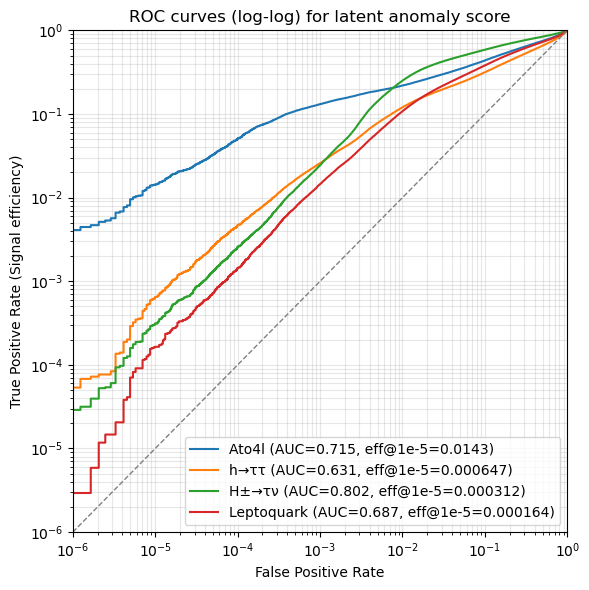

Ato4l        efficiency @ FPR=1e-5 : 1.43 %
h→ττ         efficiency @ FPR=1e-5 : 0.0647 %
H±→τν        efficiency @ FPR=1e-5 : 0.0312 %
Leptoquark   efficiency @ FPR=1e-5 : 0.0164 %


In [28]:
# ------------------------------------------------------------------
# 2. build ROC curves
# ------------------------------------------------------------------
signals = {
    "Ato4l"       : ato4l_scores,
    "h→ττ"        : hTauTau_scores,
    "H±→τν"       : hChTauNu_scores,
    "Leptoquark"  : lq_scores,
}

target_fpr = 1e-5
eff_at_target = {}

plt.figure(figsize=(6,6))
for name, s_scores in signals.items():
    y_true = np.concatenate([np.zeros_like(bg_scores), np.ones_like(s_scores)])
    y_pred = np.concatenate([bg_scores, s_scores])

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # interpolate efficiency at target FPR
    eff = np.interp(target_fpr, fpr, tpr)
    eff_at_target[name] = eff
    
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f}, eff@1e-5={eff:.3g})")

# chance line
plt.plot([1e-6,1], [1e-6,1], "--", color="grey", lw=1)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-6, 1)
plt.ylim(1e-6, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Signal efficiency)")
plt.title("ROC curves (log‑log) for latent anomaly score")
plt.legend()
plt.grid(alpha=0.3, which="both")
plt.tight_layout()
plt.savefig("../plots/roc_latent_anomaly_loglog.png")
plt.show()

# print efficiencies
for n, e in eff_at_target.items():
    print(f"{n:12s} efficiency @ FPR=1e-5 : {e*100:.3g} %")

In [ ]:
import plotly.graph_objs as go

# choose three latent axes
dims = (0, 1, 2)

def subsample(arr, n=500):
    if arr.shape[0] > n:
        idx = np.random.choice(arr.shape[0], n, replace=False)
        return arr[idx]
    return arr

traces = [
    (subsample(z_background),   'Background',   'x'),
    (subsample(z_hToTauTau),    'hToTauTau',    'diamond'),
    (subsample(z_hChToTauNu),   'hChToTauNu',   'square'),
    (subsample(z_leptoquark),   'Leptoquark',   'cross'),
    (subsample(z_Ato4l),        'Ato4l',        'circle'),
]

fig = go.Figure()

for arr, name, symbol in traces:
    fig.add_trace(go.Scatter3d(
        x=arr[:, dims[0]],
        y=arr[:, dims[1]],
        z=arr[:, dims[2]],
        mode='markers',
        name=name,
        marker=dict(size=3, symbol=symbol, opacity=0.6)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title=f'z_{dims[0]}',
        yaxis_title=f'z_{dims[1]}',
        zaxis_title=f'z_{dims[2]}'),
    width=900, height=700,
    margin=dict(l=0, r=0, b=0, t=40),
    title='Interactive 3-D latent space'
)

fig.show()

: 